In [15]:
!pip install lime

In [16]:
!pip install catboost

#Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostClassifier

In [18]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [19]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## CatBoost Classifier Model


CatBoost Evaluation
Accuracy: 0.94
Precision: 0.93
Recall: 0.96
F1 Score: 0.95
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       544
           1       0.93      0.96      0.95       635

    accuracy                           0.94      1179
   macro avg       0.95      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



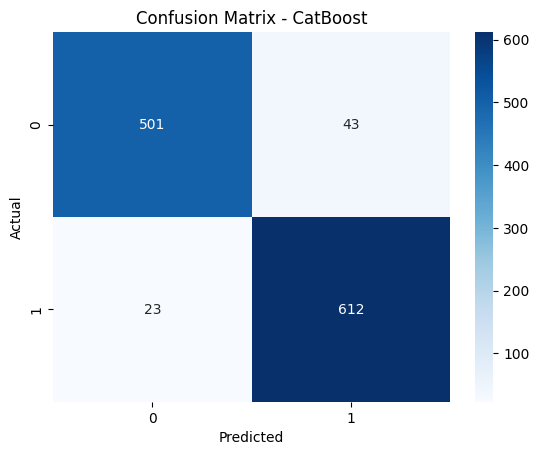

In [20]:
cat_final = CatBoostClassifier(verbose=False, random_state=42)
cat_final.fit(X_train_final, y_train)
evaluate_model("CatBoost", cat_final, X_test_final, y_test)

### SHAP for CatBoost


SHAP Summary for CatBoost


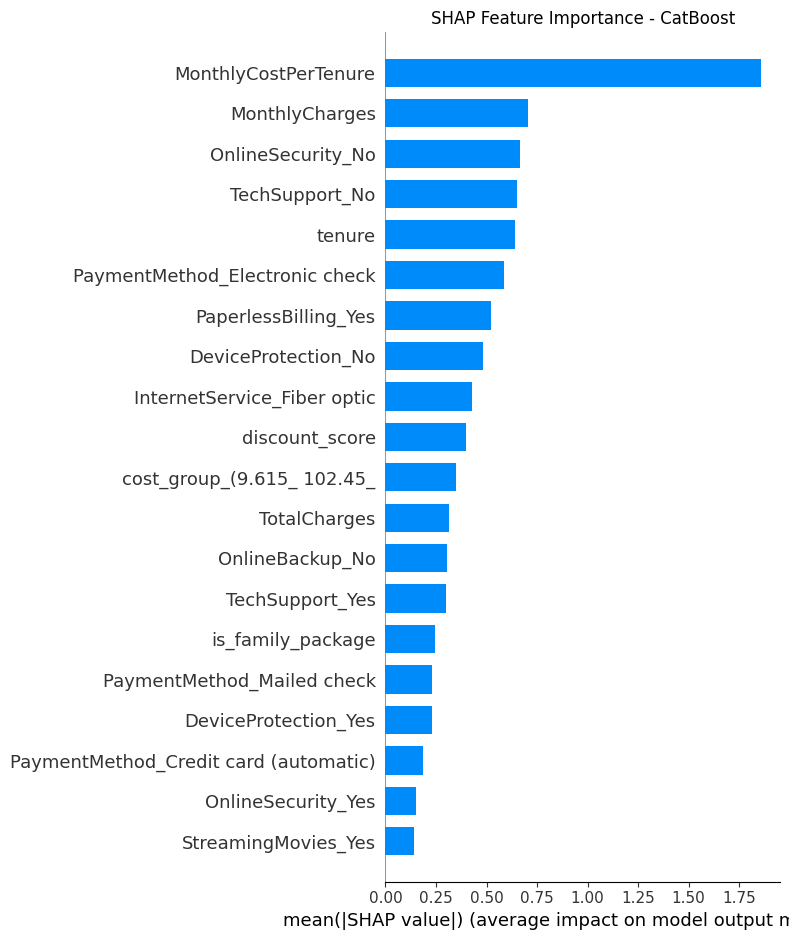

In [21]:
print("\nSHAP Summary for CatBoost")
explainer_cat = shap.TreeExplainer(cat_final)
shap_values_cat = explainer_cat.shap_values(X_test_final)
shap.summary_plot(shap_values_cat, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - CatBoost")
plt.tight_layout()
plt.show()

This SHAP bar plot shows the global feature importance in predicting customer churn:

* MonthlyCostPerTenure is by far the most influential feature, indicating that customers paying a high amount per tenure period are significantly more likely to churn.

* MonthlyCharges and OnlineSecurity_No follow, suggesting that high charges and lack of security services are strong churn drivers.

* Features like TechSupport_No, tenure, and PaymentMethod_Electronic check also contribute substantially—shorter tenure and electronic check payments are often associated with churn.

* Lower-ranked features, such as StreamingMovies_Yes and OnlineSecurity_Yes, have a weaker overall influence on model decisions.

The CatBoost model relies most heavily on billing-related features and service unavailability (like missing security or tech support) to predict churn.

### LIME for CatBoost

In [22]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [23]:
print("\nLIME Explanation for CatBoost")
exp = explainer.explain_instance(sample_instance.values, cat_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for CatBoost


This LIME explanation provides a local interpretation for a single customer prediction:

* The model predicts a 74% probability of churn.

* The most influential feature pushing the prediction toward churn is high MonthlyCostPerTenure (43.80), contributing 0.42 to the decision.

* Additional churn indicators include:

    * Lack of OnlineSecurity, TechSupport, and DeviceProtection

    * Use of Electronic check as a payment method

In contrast, features like TechSupport_Yes, PaperlessBilling_Yes, and use of credit card or mailed check for payment slightly counter the churn prediction.

For this specific customer, high payment relative to tenure, combined with the absence of support/security services and risky payment method, significantly raised the model’s confidence in predicting churn.

### PDP for CatBoost

In [24]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - CatBoost


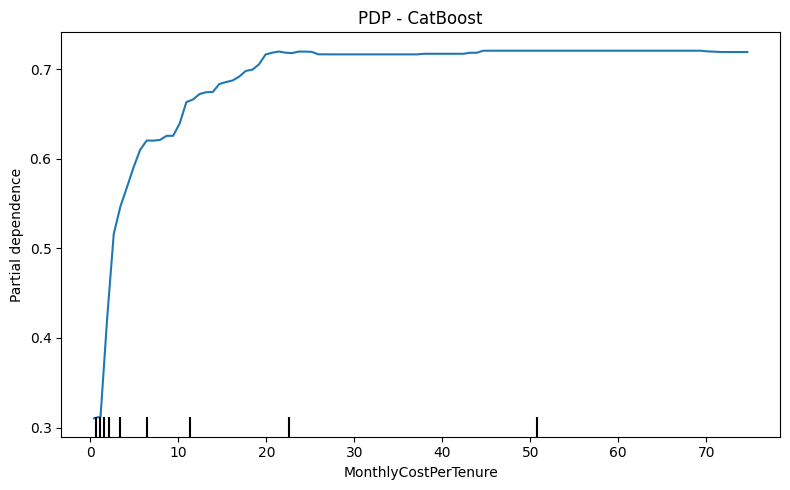

In [25]:
print("\nPDP - CatBoost")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(cat_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - CatBoost")
plt.tight_layout()
plt.show()

This Partial Dependence Plot shows how the feature MonthlyCostPerTenure affects the model’s prediction of churn:

  * The partial dependence rises steeply as MonthlyCostPerTenure increases, particularly in the 0 to 10 range.

  * Beyond a value of ~25, the curve plateaus, indicating that further increases in this feature do not significantly raise the predicted churn probability.

Customers who pay more per month relative to how long they've stayed are much more likely to churn. The risk stabilizes once the value reaches a high threshold, suggesting a saturation point in the model’s sensitivity to this feature.

### ICE for CatBoost

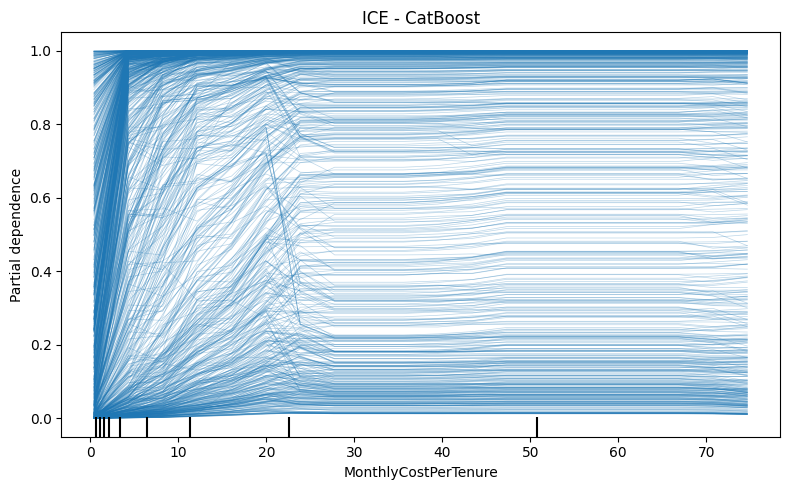

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(cat_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - CatBoost")
plt.tight_layout()
plt.show()

This ICE illustrates how the feature MonthlyCostPerTenure influences churn predictions at the individual customer level:

* Each line represents a single customer and how their predicted churn probability would change if only MonthlyCostPerTenure varied, while all other features remained fixed.

* The plot shows a consistent upward trend for many customers when MonthlyCostPerTenure increases from 0 to ~20, meaning their churn probability increases with cost.

* Beyond ~25, many lines flatten, indicating that higher values do not further affect the churn prediction for most customers.

* A few customers show non-linear or unexpected behavior, but the majority follow a similar increasing trend.

Higher MonthlyCostPerTenure strongly increases churn likelihood for many customers, especially in the low-to-mid range, reinforcing the PDP’s conclusion. ICE plots add value by revealing how individual responses differ even when the global trend is clear.